<h2> Laboratory Session 6 Inverse Kinematics with Vision Sensor in CoppeliaSim with suction cup manipulator</h2>

<br>- Requires that the files 'sim.py', 'simConst.py', 'remoteapi.dll' be hosted in the same folder as this Jupyter notebook. It also requires using the attached scene: RobotScaraManIKCV.ttt where a Scara robot and a pre-programmed pneumatic actuator (suction cup) appear to pick up and drop elements.
<br>- You have these files in the folder attached to the session (laboratories6.zip)

<br>- Requires installing the CV libraries from Anaconda:

<br> From Anaconda Terminal:

<br>- Step 1 - installing OpenCV 
<br>pip install opencv-python
<br>python
<br>import cv2

<br>- Step 2 - Check 
<br>OpenCV Version 
<br>cv2.version 
<br>exit()

<br>If you fail, look  https://programarfacil.com/blog/vision-artificial/instalar-opencv-python-anaconda/

Bibliography used outlines in openCV
https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_contours/py_contour_properties/py_contour_properties.html

About the openCV and Jupyter Notebooks windows problem:
https://medium.com/@mrdatainsight/how-to-use-opencv-imshow-in-a-jupyter-notebook-quick-tip-ce83fa32b5ad


#### Although I give you the already created scene of this robot, I show you how I added the image sensor and modified its properties:

In [1]:
from IPython.display import YouTubeVideo

YouTubeVideo('unUjA_YVZnM')

<br><h4> Remember:</h4>
<br>1. Open the scene RobotScaraManIKCV.ttt
<br>2. Check that the camera can see the object when you press play, the Image Sensor can only see "renderable" objects.
<br>3. Remember that the Coppelia scene must be in PLAY to be controlled from Jupyter.


In [2]:
# we import the necessary libraries
import sim          
import sympy as sp  

### 0. We establish the connection
We will use the functions of the COPPELIA Remote API.

In [3]:
def connect(port):

    clientID=sim.simxStart('127.0.0.1',port,True,True,2000,5) # Conectarse
    if clientID == 0: print("conectado a", port)
    else: print("no se pudo conectar")
    return clientID

<h3> 1. Suction cup control </h3>
Function that allows you to activate or deactivate the Coppelia suction cup from Jupyter. There are instructions in the Coppelia suctionPad scripts that allow remote use.

In [4]:
# we import the necessary libraries
import sim          
import sympy as sp  

def connect(port):

    clientID=sim.simxStart('127.0.0.1',port,True,True,2000,5) # Conectarse
    if clientID == 0: print("conectado a", port)
    else: print("no se pudo conectar")
    return clientID

def setEffector(val):
# function that triggers the end effector remotely
# val is Int with value 0 or 1 to disable or activate the final actuator.
    res,retInts,retFloats,retStrings,retBuffer=sim.simxCallScriptFunction(clientID,
        "suctionPad", sim.sim_scripttype_childscript,"setEffector",[val],[],[],"", sim.simx_opmode_blocking)
    return res

# We require the handlers for the joints, the suction cup and the camera sensor
clientID = connect(19999)
retCode,suction=sim.simxGetObjectHandle(clientID,'suctionPad',sim.simx_opmode_blocking)
retCode,sensorHandle=sim.simxGetObjectHandle(clientID,'Vision_sensor',sim.simx_opmode_blocking)
retCode,joint1=sim.simxGetObjectHandle(clientID,'Joint1',sim.simx_opmode_blocking)
retCode,joint2=sim.simxGetObjectHandle(clientID,'Joint2',sim.simx_opmode_blocking)
retCode,joint3=sim.simxGetObjectHandle(clientID,'Joint3',sim.simx_opmode_blocking)
print(suction, sensorHandle, joint1, joint2, joint3)

# We send the positions to the joints, the first two in radians

q = [0, 0, -0.0] #Home position and prism retracted (Suction Cup Up)

retCode = sim.simxSetJointTargetPosition(clientID, joint1, q[0], sim.simx_opmode_oneshot)
retCode = sim.simxSetJointTargetPosition(clientID, joint2, q[1], sim.simx_opmode_oneshot)
retCode = sim.simxSetJointTargetPosition(clientID, joint3, q[2], sim.simx_opmode_oneshot)


conectado a 19999
22 29 17 19 21


<h3> 2. We obtain the controllers (handlers) of the Joints, Suction Cup and Camera Sensor</h3>


In [5]:
# We send the positions to the joints, the first two in radians

q = [0, 0, -0.0] #Home position and prism retracted (Suction Cup Up)

retCode = sim.simxSetJointTargetPosition(clientID, joint1, q[0], sim.simx_opmode_oneshot)
retCode = sim.simxSetJointTargetPosition(clientID, joint2, q[1], sim.simx_opmode_oneshot)
retCode = sim.simxSetJointTargetPosition(clientID, joint3, q[2], sim.simx_opmode_oneshot)

# We obtain the image from the Camera Sensor
retCode, resolution, image=sim.simxGetVisionSensorImage(clientID,sensorHandle,0,sim.simx_opmode_oneshot_wait)

In [6]:
# we deactivate the final actuator (suction cup)
setEffector(0)

0

<h3> 3. We prepare the acquisition of the Image to obtain the coordinates of the piece and thus find a solution to the equations</h3>


In [7]:
import numpy as np
import sympy as sp
import cv2                      # opencv
import matplotlib.pyplot as plt # pyplot
from sympy import *
from sympy.physics.vector import init_vprinting

init_vprinting(use_latex='mathjax', pretty_print=False)
from sympy.physics.mechanics import dynamicsymbols
theta1, theta2, d3, lc, la, lb, theta, alpha, a, d = dynamicsymbols('theta1 theta2 d3 lc la lb theta alpha a d')
theta1, theta2, d3, lc, la, lb, theta, alpha, a, d 

(theta1, theta2, d3, lc, la, lb, theta, alpha, a, d)

In [8]:
# We obtain the image from the Camera Sensor
retCode, resolution, image=sim.simxGetVisionSensorImage(clientID,sensorHandle,0,sim.simx_opmode_oneshot_wait)
len(image)


196608

In [9]:
resolution

[256, 256]

In [10]:
#It is an image with a resolution of 256*256 and each pixel is RGB
256*256*3

196608

C:\Users\neild\AppData\Local\Temp\ipykernel_9008\894198614.py:1: DeprecationWarning: NumPy will stop allowing conversion of out-of-bound Python integers to integer arrays.  The conversion of -41 to uint8 will fail in the future.
For the old behavior, usually:
    np.array(value).astype(dtype)
will give the desired result (the cast overflows).
  img=np.array(image,dtype=np.uint8)
C:\Users\neild\AppData\Local\Temp\ipykernel_9008\894198614.py:1: DeprecationWarning: NumPy will stop allowing conversion of out-of-bound Python integers to integer arrays.  The conversion of -48 to uint8 will fail in the future.
For the old behavior, usually:
    np.array(value).astype(dtype)
will give the desired result (the cast overflows).
  img=np.array(image,dtype=np.uint8)
C:\Users\neild\AppData\Local\Temp\ipykernel_9008\894198614.py:1: DeprecationWarning: NumPy will stop allowing conversion of out-of-bound Python integers to integer arrays.  The conversion of -66 to uint8 will fail in the future.
For the

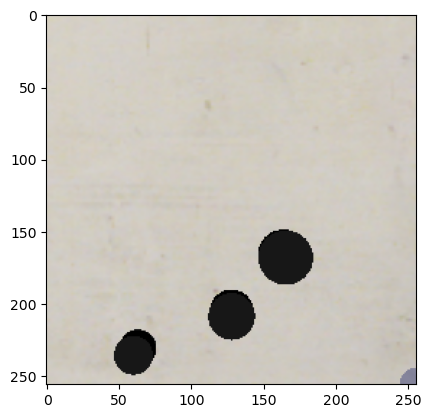

In [11]:
img=np.array(image,dtype=np.uint8)
img.resize([resolution[1],resolution[0],3])
plt.imshow(img)
plt.show()

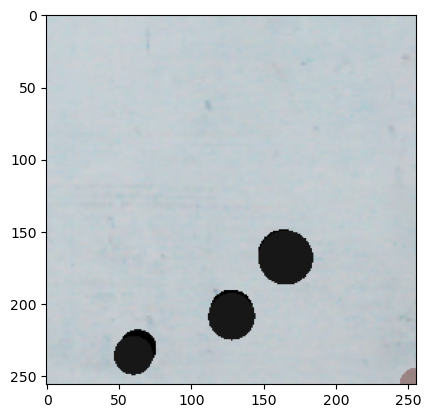

In [12]:
#CV library in Python can only work on BGR, GRAY or binarized images
img_BGR = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
plt.imshow(img_BGR)
plt.show()

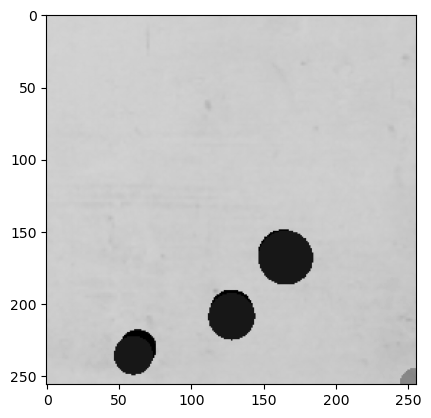

In [13]:
img_GRAY = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
plt.imshow(img_GRAY, cmap='gray', vmin=0,vmax=255)
plt.show()

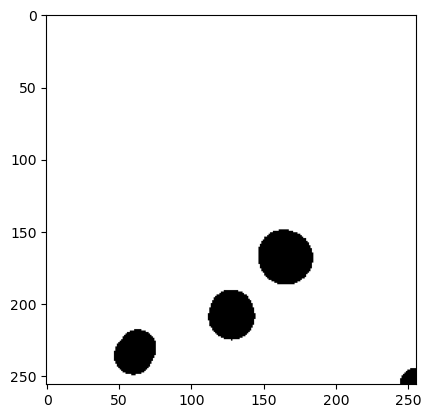

In [14]:

ret, thresh = cv2.threshold(img_GRAY,150,255,cv2.THRESH_BINARY)
plt.imshow(thresh, cmap='gray', vmin=0,vmax=255)
plt.show()

In [15]:
#We can also use a function to automatically detect blobs directly with SimpleBlobDetector
# the BGR, GRAY or binarized image can be used directly

#def init_blob_detector():
# params = cv2.SimpleBlobDetector_Params()
# params.minThreshold = 1
# params.maxThreshold = 255
# params.filterByArea = True
# params.minArea = 1
# params.filterByCircularity = False
# params.filterByConvexity = False
# params.filterByInertia = False

detector=cv2.SimpleBlobDetector_create() #Verion antigua !!
keypoints=detector.detect(thresh)
print(keypoints)


(< cv2.KeyPoint 0000027F635FFCF0>, < cv2.KeyPoint 0000027F657CB6C0>, < cv2.KeyPoint 0000027F6572D930>)


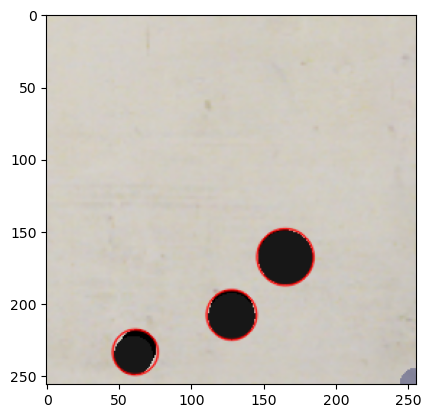

In [16]:
#image with blobs and marks
imagen_with_keypoints=cv2.drawKeypoints(img_BGR,keypoints,np.array([]),(0,0,255),cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
#show image with keypoints
plt.imshow(cv2.cvtColor(imagen_with_keypoints,cv2.COLOR_BGR2RGB))


In [17]:
xi,yi,si=0,0,0
print ('blobs found:')
print (len(keypoints))



blobs found:
3


In [18]:
print ("   X     Y    AREA in the image")
info = {1:[0,0,0], 2:[0,0,0], 3:[0,0,0]}
for i, keyPoint in enumerate(keypoints):
    if (keyPoint.size>10): #If the area of the object is greater than 10
        xi = N(keyPoint.pt[0],5)    
        yi = N(keyPoint.pt[1],5)
        si = N(keyPoint.size,5)
        info[i+1] = xi,yi,si
        print (xi,yi,si)

   X     Y    AREA in the image
61.288 233.46 31.262
127.95 207.67 34.557
165.12 167.69 39.129


In [19]:
sorted(info.items(), key=lambda x: x[1][0], reverse=True)

[(3, (165.12, 167.69, 39.129)), (2, (127.95, 207.67, 34.557)), (1, (61.288, 233.46, 31.262))]

In [20]:
 
print ("Position X,Y in the scene:")
x = N(0.5-xi*0.5/256,2)   
y = N(0.5-yi*0.5/256,2)
print (x,y)


Position X,Y in the scene:
0.18 0.17


In [21]:
z=0.021  #We mark the height to pick up the piece with the suction cup.
print(x,y,z)

0.18 0.17 0.021


<h3> 4. We send previously calculated angles to each axis </h3>

In [22]:
retCode = sim.simxSetJointTargetPosition(clientID, joint1, q[0], sim.simx_opmode_oneshot) # PAsar los datos en Radianes
retCode = sim.simxSetJointTargetPosition(clientID, joint2, q[1], sim.simx_opmode_oneshot)
retCode = sim.simxSetJointTargetPosition(clientID, joint3, -q[2], sim.simx_opmode_oneshot)

In [23]:
# we activate the final actuator (suction cup)
setEffector(1)

0

In [24]:

q[2] = 0.04
retCode = sim.simxSetJointTargetPosition(clientID, joint3, -q[2], sim.simx_opmode_oneshot)

<h3> 5. Build a sequence of movements </h3>

#### Using the procedure for calculating inverse kinematics and the time library, try to place the three existing objects on top of each other by size (from Largest to Smallest).


<br>- Note1: We can use the existing blob detection function to look at the Area of ​​each object and prepare the sequence
<br> You can also use other libraries or functions that you know about Computer Vision, this part is free
<br>- Note2: we can create the sequence by importing the time library and using time.sleep(time in seconds)
<br> import time
<br> time.sleep(1)


In [25]:

info

{1: (61.288, 233.46, 31.262), 2: (127.95, 207.67, 34.557), 3: (165.12, 167.69, 39.129)}

In [26]:
z=0.021 

In [27]:
eq_list = []
    
for k, v in info.items():
    
    x = N(0.5-v[0]*0.5/256,2)   
    y = N(0.5-v[1]*0.5/256,2)
    
    eq1 = 0.2 * cos(theta1) + 0.2 * cos(theta1 + theta2) - x
    eq2 = 0.2 * sin(theta1) + 0.2 * sin(theta1 + theta2) - y
    eq3 = 0.105 - d3 - z
    eqi = [eq1, eq2, eq3]
    
    eq_list.append(eqi)
    #print (x,y)


In [28]:
eq_list

[[0.2*cos(theta1 + theta2) + 0.2*cos(theta1) - 0.38, 0.2*sin(theta1 + theta2) + 0.2*sin(theta1) - 0.044, 0.084 - d3], [0.2*cos(theta1 + theta2) + 0.2*cos(theta1) - 0.25, 0.2*sin(theta1 + theta2) + 0.2*sin(theta1) - 0.094, 0.084 - d3], [0.2*cos(theta1 + theta2) + 0.2*cos(theta1) - 0.18, 0.2*sin(theta1 + theta2) + 0.2*sin(theta1) - 0.17, 0.084 - d3]]

In [29]:
qs= []
for eqs in eq_list:
    
    # We lowered the precision to 5 figures to make it easier for you to find the solution
    try:
        q=nsolve((eqs[0],eqs[1],eqs[2]),(theta1,theta2,d3),(1,1,1),prec=5)
        qs.append(q)
    except:
        print('No solution found')
        q=[0,0,0]


In [30]:
q3 = qs[2]
qs = qs[0:2]
qs.reverse()

In [31]:
len(qs)

2

In [32]:
import time
for q in qs:
    retCode = sim.simxSetJointTargetPosition(clientID, joint1, q[0], sim.simx_opmode_oneshot) # PAsar los datos en Radianes
    retCode = sim.simxSetJointTargetPosition(clientID, joint2, q[1], sim.simx_opmode_oneshot)
    # we activate the final actuator (suction cup)
    time.sleep(1)
    retCode = sim.simxSetJointTargetPosition(clientID, joint3, -q[2], sim.simx_opmode_oneshot)
    setEffector(1)
    time.sleep(1)
    q[2] = 0.07
    retCode = sim.simxSetJointTargetPosition(clientID, joint3, q[2], sim.simx_opmode_oneshot)
    
    time.sleep(1)
    retCode = sim.simxSetJointTargetPosition(clientID, joint1, q3[0], sim.simx_opmode_oneshot) # PAsar los datos en Radianes
    retCode = sim.simxSetJointTargetPosition(clientID, joint2, q3[1], sim.simx_opmode_oneshot)
    time.sleep(1)
    retCode = sim.simxSetJointTargetPosition(clientID, joint3, -0.5 * q3[2], sim.simx_opmode_oneshot)
    time.sleep(1)
    setEffector(0)
    time.sleep(1)
    q[2] = 0.07
    
    time.sleep(1)
    setEffector(0)
    retCode = sim.simxSetJointTargetPosition(clientID, joint3, q[2], sim.simx_opmode_oneshot)
    
time.sleep(1)
    
   

Remember that you have to teach the professor how it works in the laboratory and each student must hand in this complete Jupyter notebook on the virtual campus.